In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, concatenate, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib

In [7]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

# Data tidying

In [3]:
def clean_data(data):
    #transforming date variable
    data['date_GMT'] = pd.to_datetime(data['date_GMT'])
    data['date'] = pd.to_datetime(data['date_GMT'].dt.date)
    data['time'] = data['date_GMT'].dt.time
    
    #adding aggregated variables
    data['corners_total'] = data['home_team_corner_count'] + data['away_team_corner_count']
    data['yellow_cards_total'] = data['home_team_yellow_cards'] + data['away_team_yellow_cards']
    data['red_cards_total'] = data['home_team_red_cards'] + data['away_team_red_cards']
    data['cards_total'] = data['yellow_cards_total'] + data['red_cards_total']
    data['shots_total'] = data['home_team_shots'] + data['away_team_shots']
    data['shots_on_target_total'] = data['home_team_shots_on_target'] + data['away_team_shots_on_target']
    data['shots_off_target_total'] = data['home_team_shots_off_target'] + data['away_team_shots_off_target']
    data['fouls_total'] = data['home_team_fouls'] + data['away_team_fouls']
    
    #getting stadium names without city in brackets
    # data['base_name'] = data['stadium_name'].str.replace(r" \(.*\)$", "", regex=True)

    # city_map = data[data['stadium_name'].str.contains(r"\(.*\)")].copy()
    # city_map['city'] = city_map['stadium_name'].str.extract(r"\((.*?)\)")[0]
    # city_map = city_map.groupby('base_name')['city'].agg(pd.Series.mode).to_dict()

    # #filling stadium names without city in brackets
    # data['normalized_stadium'] = data.apply(lambda row: f"{row['base_name']} ({city_map.get(row['base_name'], 'Unknown')})" if '(' not in row['stadium_name'] else row['stadium_name'], axis=1)

    #dropping unnecessary features
    data.drop(['Unnamed: 0', 'timestamp', 'status', 'home_team_goal_timings', 'away_team_goal_timings', 'date_GMT'], axis=1, inplace=True)
    
    #setting one of the target variable - result of the game
    data['result'] = np.where(data['home_team_goal_count'] == data['away_team_goal_count'], 0, np.where(data['home_team_goal_count'] > data['away_team_goal_count'], 1, 2))
    
    def assign_season(date):
        year = date.year
        if date.month >= 8:  # Sezon zaczyna się w sierpniu
            return f'{str(year)[2:]}/{str(year+1)[2:]}'
        else:
            return f'{str(year-1)[2:]}/{str(year)[2:]}'
    
    data['season'] = data['date'].apply(assign_season)
    
    return data

In [4]:
data = pd.read_csv('./data/all_games.csv')

In [5]:
data = clean_data(data)

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33128\694537563.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date_GMT'] = pd.to_datetime(data['date_GMT'])


In [6]:
data.head()

,attendance,home_team_name,away_team_name,referee,Game Week,Pre-Match PPG (Home),Pre-Match PPG (Away),home_ppg,away_ppg,home_team_goal_count,...,corners_total,yellow_cards_total,red_cards_total,cards_total,shots_total,shots_on_target_total,shots_off_target_total,fouls_total,result,season
0,NaN,Wolfsburg,Stuttgart,Felix Brych,1.0,0.0,0.0,1.35,1.53,2,...,-2,-2,-2,-4,-2,-2,-2,-2,1,09/10
1,NaN,Borussia Dortmund,Köln,Wolfgang Stark,1.0,0.0,0.0,2.00,1.35,1,...,-2,1,0,1,-2,-2,-2,-2,1,09/10
2,NaN,Nürnberg,Schalke 04,Knut Kircher,1.0,0.0,0.0,1.12,1.76,1,...,-2,3,0,3,-2,-2,-2,-2,2,09/10
3,NaN,Werder Bremen,Eintracht Frankfurt,NaN,1.0,0.0,0.0,1.76,1.18,2,...,-2,4,1,5,-2,-2,-2,-2,2,09/10
4,NaN,Hertha BSC,Hannover 96,Guido Winkmann,1.0,0.0,0.0,0.53,0.82,1,...,-2,5,0,5,-2,-2,-2,-2,1,09/10


# Data preprocessing

In [8]:
le = LabelEncoder()

In [9]:
data['home_team_le'] = le.fit_transform(data['home_team_name'])
data['away_team_le'] = le.fit_transform(data['away_team_name'])

In [17]:
# Zapisanie LabelEncoder
import joblib
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

In [18]:
num_teams = len(le.classes_)

In [10]:
# Używamy historycznych danych podczas treningu
historical_stats = data[['home_ppg', 'away_ppg', 'home_team_goal_count', 'away_team_goal_count', 'total_goal_count', 
                         'total_goals_at_half_time', 'home_team_goal_count_half_time', 'away_team_goal_count_half_time', 
                         'home_team_corner_count', 'away_team_corner_count', 'home_team_yellow_cards', 'away_team_yellow_cards', 
                         'home_team_red_cards', 'away_team_red_cards', 'home_team_shots', 'away_team_shots', 
                         'home_team_shots_on_target', 'away_team_shots_on_target', 'home_team_shots_off_target', 
                         'away_team_shots_off_target', 'home_team_fouls', 'away_team_fouls', 'home_team_possession', 
                         'away_team_possession', 'Home Team Pre-Match xG', 'Away Team Pre-Match xG']]

In [12]:
# Znalezienie ostatnich pięciu wyników dla każdej drużyny
def get_last_results(team_id, date, rows=5):
    past_games = data[(data['date'] < date) & 
                      ((data['home_team_le'] == team_id) | 
                       (data['away_team_le'] == team_id))].tail(rows)
    results = []
    for _, row in past_games.iterrows():
        if row['home_team_le'] == team_id:
            results.append(row['home_team_goal_count'] - row['away_team_goal_count'])
        else:
            results.append(row['away_team_goal_count'] - row['home_team_goal_count'])
    # Dopisz zera jeśli nie ma wystarczającej liczby meczów
    results += [0] * (rows - len(results))
    return results

data['home_last_5'] = data.apply(lambda x: get_last_results(x['home_team_le'], x['date']), axis=1)
data['away_last_5'] = data.apply(lambda x: get_last_results(x['away_team_le'], x['date']), axis=1)

In [19]:
def prepare_form(form_series):
    return np.array(form_series.tolist())

In [15]:
data['home_last_5']

0         [-1, 0, 0, 0, 0]
1          [0, 0, 0, 0, 0]
2          [0, 0, 0, 0, 0]
3         [-2, 0, 0, 0, 0]
4          [4, 0, 0, 0, 0]
               ...        
66075     [-2, 1, 0, 2, 2]
66076    [1, -2, 0, 3, -2]
66077    [1, 0, 1, -2, -2]
66078    [-2, 0, 1, -3, 1]
66079      [2, 2, 3, 3, 3]
Name: home_last_5, Length: 66080, dtype: object

In [38]:
X_home_train = prepare_form(data['home_last_5'])
X_away_train = prepare_form(data['away_last_5'])
X_home_test = prepare_form(data['home_last_5'])
X_away_test = prepare_form(data['away_last_5'])

In [39]:
# Podział na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(data, data[['result', 'total_goal_count', 'total_goals_at_half_time', 'home_team_corner_count', 'away_team_corner_count', 'home_team_yellow_cards', 'away_team_yellow_cards']], test_size=0.2, random_state=42)

In [40]:
X_home_team_train = X_train['home_team_le'].values
X_away_team_train = X_train['away_team_le'].values
X_home_team_test = X_test['home_team_le'].values
X_away_team_test = X_test['away_team_le'].values

In [41]:
# Konwersja etykiet do one-hot encoding dla rezultatu
y_train_result = np.eye(3)[y_train['result']]
y_test_result = np.eye(3)[y_test['result']]

# Model

In [42]:
# Przygotowanie danych statystycznych
historical_stats_train = X_train[['home_ppg', 'away_ppg', 'home_team_goal_count', 'away_team_goal_count', 'total_goal_count', 
                                  'total_goals_at_half_time', 'home_team_goal_count_half_time', 'away_team_goal_count_half_time', 
                                  'home_team_corner_count', 'away_team_corner_count', 'home_team_yellow_cards', 'away_team_yellow_cards', 
                                  'home_team_red_cards', 'away_team_red_cards', 'home_team_shots', 'away_team_shots', 
                                  'home_team_shots_on_target', 'away_team_shots_on_target', 'home_team_shots_off_target', 
                                  'away_team_shots_off_target', 'home_team_fouls', 'away_team_fouls', 'home_team_possession', 
                                  'away_team_possession', 'Home Team Pre-Match xG', 'Away Team Pre-Match xG']].values

historical_stats_test = X_test[['home_ppg', 'away_ppg', 'home_team_goal_count', 'away_team_goal_count', 'total_goal_count', 
                                'total_goals_at_half_time', 'home_team_goal_count_half_time', 'away_team_goal_count_half_time', 
                                'home_team_corner_count', 'away_team_corner_count', 'home_team_yellow_cards', 'away_team_yellow_cards', 
                                'home_team_red_cards', 'away_team_red_cards', 'home_team_shots', 'away_team_shots', 
                                'home_team_shots_on_target', 'away_team_shots_on_target', 'home_team_shots_off_target', 
                                'away_team_shots_off_target', 'home_team_fouls', 'away_team_fouls', 'home_team_possession', 
                                'away_team_possession', 'Home Team Pre-Match xG', 'Away Team Pre-Match xG']].values

In [43]:
print(X_home_train.shape)
print(X_away_train.shape)
print(X_home_team_train.shape)
print(X_away_team_train.shape)
print(historical_stats_train.shape)

print(y_result_one_hot.shape)
print(y_total_goals.shape)
print(y_total_corners.shape)
print(y_total_cards.shape)


(66080, 5)
(66080, 5)
(52864,)
(52864,)
(52864, 26)
(52864, 3)
(52864,)
(52864,)
(52864,)


In [37]:
# Assuming X_train and y_train are already defined and contain the correct subset of data

# Encode the team names again to ensure they match the training set
X_home_team_train = le.transform(X_train['home_team_name'])
X_away_team_train = le.transform(X_train['away_team_name'])

# Extract the historical stats
historical_stats_train = X_train[['home_ppg', 'away_ppg', 'home_team_goal_count', 'away_team_goal_count', 
                                  'total_goal_count', 'total_goals_at_half_time', 'home_team_corner_count', 
                                  'away_team_corner_count', 'home_team_yellow_cards', 'away_team_yellow_cards', 
                                  'home_team_red_cards', 'away_team_red_cards', 'home_team_first_half_cards', 
                                  'away_team_first_half_cards', 'home_team_second_half_cards', 
                                  'away_team_second_half_cards', 'home_team_shots', 'away_team_shots', 
                                  'home_team_shots_on_target', 'away_team_shots_on_target', 
                                  'home_team_shots_off_target', 'away_team_shots_off_target', 'home_team_fouls', 
                                  'away_team_fouls', 'home_team_possession', 'away_team_possession']].values

# Re-encode the labels if necessary to ensure they match
y_result_one_hot = pd.get_dummies(y_train['result']).values
y_total_goals = y_train['total_goal_count'].values
y_total_corners = y_train['corners_total'].values
y_total_cards = y_train['cards_total'].values

# Now check shapes again
print(X_home_team_train.shape)
print(X_away_team_train.shape)
print(historical_stats_train.shape)

print(y_result_one_hot.shape)
print(y_total_goals.shape)
print(y_total_corners.shape)
print(y_total_cards.shape)

ValueError: y contains previously unseen labels: 'Kaisar'

In [33]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, concatenate, Dropout
from keras.regularizers import l2

# Wejścia
home_form_input = Input(shape=(5,))
away_form_input = Input(shape=(5,))
home_team_input = Input(shape=(1,))
away_team_input = Input(shape=(1,))
stats_input = Input(shape=(26,))

# Embedding dla drużyn
home_team_embedding = Embedding(input_dim=num_teams, output_dim=32)(home_team_input)
home_team_embedding = Flatten()(home_team_embedding)

away_team_embedding = Embedding(input_dim=num_teams, output_dim=32)(away_team_input)
away_team_embedding = Flatten()(away_team_embedding)

# Połączenie wszystkich wejść
merged = concatenate([home_form_input, away_form_input, home_team_embedding, away_team_embedding, stats_input])
merged = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(merged)
merged = Dropout(0.5)(merged)
merged = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(merged)
merged = Dropout(0.5)(merged)

# Warstwy wyjściowe
result_output = Dense(3, activation='softmax', name='result')(merged)
goals_output = Dense(1, activation='linear', name='total_goals')(merged)
corners_output = Dense(1, activation='linear', name='total_corners')(merged)
cards_output = Dense(1, activation='linear', name='total_cards')(merged)

# Tworzenie modelu
model = Model(inputs=[home_form_input, away_form_input, home_team_input, away_team_input, stats_input],
              outputs=[result_output, goals_output, corners_output, cards_output])

model.compile(optimizer='adam',
              loss={'result': 'categorical_crossentropy', 'total_goals': 'mse', 'total_corners': 'mse', 'total_cards': 'mse'},
              metrics={'result': 'accuracy', 'total_goals': 'mse', 'total_corners': 'mse', 'total_cards': 'mse'})

# Finally, train the model again
history = model.fit(
    [X_home_train, X_away_train, X_home_team_train, X_away_team_train, historical_stats_train],
    {'result': y_result_one_hot, 'total_goals': y_total_goals, 'total_corners': y_total_corners, 'total_cards': y_total_cards},
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

# Ewaluacja modelu
loss, accuracy, mse_goals, mse_corners, mse_cards = model.evaluate(
    [X_home_test, X_away_test, X_home_team_test, X_away_team_test, historical_stats_test],
    {'result': y_result_one_hot, 'total_goals': y_total_goals, 'total_corners': y_total_corners, 'total_cards': y_total_cards}
)
print(f'Test loss: {loss}, Test accuracy: {accuracy}, Test MSE Goals: {mse_goals}, Test MSE Corners: {mse_corners}, Test MSE Cards: {mse_cards}')

# Wizualizacja wyników treningu
plt.figure(figsize=(14, 6))

# Dokładność
plt.subplot(1, 2, 1)
plt.plot(history.history['result_accuracy'])
plt.plot(history.history['val_result_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Strata
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Epoch 1/50

1640/1652 [============================>.] - ETA: 0s - loss: 25.3816 - result_loss: 1.3531 - total_goals_loss: 4.6589 - total_corners_loss: 12.1576 - total_cards_loss: 6.0170 - result_accuracy: 0.4112 - total_goals_mse: 4.6589 - total_corners_mse: 12.1576 - total_cards_mse: 6.0170

ValueError: Data cardinality is ambiguous:
  x sizes: 13216, 13216, 0, 0, 0
  y sizes: 0, 0, 0, 0
Make sure all arrays contain the same number of samples.

In [32]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding dla kolumny `result`
one_hot_encoder = OneHotEncoder(sparse=False)
y_result_one_hot = one_hot_encoder.fit_transform(X_train[['result']])

# Przygotowanie pozostałych zmiennych wyjściowych
y_total_goals = X_train['total_goal_count'].values
y_total_corners = X_train['corners_total'].values
y_total_cards = X_train['cards_total'].values

# Sprawdzenie kształtów danych
print(y_result_one_hot.shape)  # Powinno być (52864, 3) dla trzech klas wyników
print(y_total_goals.shape)  # Powinno być (52864,)
print(y_total_corners.shape)  # Powinno być (52864,)
print(y_total_cards.shape)  # Powinno być (52864,)

(52864, 3)
(52864,)
(52864,)
(52864,)


c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Ewaluacja modelu
loss, accuracy, mse_goals, mse_corners, mse_cards = model.evaluate([X_home_test, X_away_test, X_test['home_team_encoded'], X_test['away_team_encoded'], historical_stats], 
                                                                   {'result': y_test_result, 'total_goals': y_test['total_goal_count'], 'total_corners': y_test[['home_team_corner_count', 'away_team_corner_count']], 'total_cards': y_test[['home_team_yellow_cards', 'away_team_yellow_cards']]})
print(f'Test loss: {loss}, Test accuracy: {accuracy}, Test MSE Goals: {mse_goals}, Test MSE Corners: {mse_corners}, Test MSE Cards: {mse_cards}')

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(14, 6))

# Dokładność
plt.subplot(1, 2, 1)
plt.plot(history.history['result_accuracy'])
plt.plot(history.history['val_result_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Strata
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predykcja

In [ ]:
# Wczytanie LabelEncoder
label_encoder = joblib.load('label_encoder.pkl')

def preprocess_input(home_team, away_team, home_form, away_form, historical_stats_mean):
    home_team_encoded = label_encoder.transform([home_team])
    away_team_encoded = label_encoder.transform([away_team])
    
    home_form_array = np.array([home_form])
    away_form_array = np.array([away_form])
    stats_array = np.array([historical_stats_mean])  # Użycie statystyk historycznych
    
    return home_form_array, away_form_array, home_team_encoded, away_team_encoded, stats_array

def predict_match(home_team, away_team, home_form, away_form):
    # Średnie wartości statystyk historycznych (przykładowe)
    historical_stats_mean = historical_stats.mean(axis=0)
    
    home_form_array, away_form_array, home_team_encoded, away_team_encoded, stats_array = preprocess_input(home_team, away_team, home_form, away_form, historical_stats_mean)
    
    prediction = model.predict([home_form_array, away_form_array, home_team_encoded, away_team_encoded, stats_array])
    predicted_result = np.argmax(prediction[0], axis=1)
    predicted_goals = prediction[1]
    predicted_corners = prediction[2]
    predicted_cards = prediction[3]
    
    return predicted_result[0], predicted_goals[0], predicted_corners[0], predicted_cards[0]


# N approach

In [52]:
from sklearn.preprocessing import LabelEncoder

# Combine all unique team names from both home and away teams
all_teams = pd.concat([data['home_team_name'], data['away_team_name']]).unique()

# Initialize and fit the LabelEncoder on all unique team names
le = LabelEncoder()
le.fit(all_teams)

# Transform the team names using the fitted LabelEncoder
data['home_team_encoded'] = le.transform(data['home_team_name'])
data['away_team_encoded'] = le.transform(data['away_team_name'])

# Define num_teams based on the total unique teams
num_teams = len(le.classes_)

In [57]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, data[['result', 'total_goal_count', 'corners_total', 'cards_total']], test_size=0.2, random_state=42)

In [58]:
from sklearn.model_selection import train_test_split

# Split the data
# X_train, X_test, y_train, y_test = train_test_split(data, test_size=0.2, random_state=42)

# Prepare the input data for the model
X_home_train = np.array(X_train['home_last_5'].tolist())
X_away_train = np.array(X_train['away_last_5'].tolist())
X_home_team_train = X_train['home_team_encoded'].values
X_away_team_train = X_train['away_team_encoded'].values
historical_stats_train = X_train[['home_ppg', 'away_ppg', 'home_team_goal_count', 'away_team_goal_count',
                                  'total_goal_count', 'total_goals_at_half_time', 'home_team_corner_count',
                                  'away_team_corner_count', 'home_team_yellow_cards', 'away_team_yellow_cards',
                                  'home_team_red_cards', 'away_team_red_cards', 'home_team_first_half_cards',
                                  'away_team_first_half_cards', 'home_team_second_half_cards',
                                  'away_team_second_half_cards', 'home_team_shots', 'away_team_shots',
                                  'home_team_shots_on_target', 'away_team_shots_on_target',
                                  'home_team_shots_off_target', 'away_team_shots_off_target', 'home_team_fouls',
                                  'away_team_fouls', 'home_team_possession', 'away_team_possession']].values

X_home_test = np.array(X_test['home_last_5'].tolist())
X_away_test = np.array(X_test['away_last_5'].tolist())
X_home_team_test = X_test['home_team_encoded'].values
X_away_team_test = X_test['away_team_encoded'].values
historical_stats_test = X_test[['home_ppg', 'away_ppg', 'home_team_goal_count', 'away_team_goal_count',
                                'total_goal_count', 'total_goals_at_half_time', 'home_team_corner_count',
                                'away_team_corner_count', 'home_team_yellow_cards', 'away_team_yellow_cards',
                                'home_team_red_cards', 'away_team_red_cards', 'home_team_first_half_cards',
                                'away_team_first_half_cards', 'home_team_second_half_cards',
                                'away_team_second_half_cards', 'home_team_shots', 'away_team_shots',
                                'home_team_shots_on_target', 'away_team_shots_on_target',
                                'home_team_shots_off_target', 'away_team_shots_off_target', 'home_team_fouls',
                                'away_team_fouls', 'home_team_possession', 'away_team_possession']].values

# Prepare the targets
y_result_one_hot = pd.get_dummies(y_train['result']).values
y_total_goals = y_train['total_goal_count'].values
y_total_corners = y_train['corners_total'].values
y_total_cards = y_train['cards_total'].values

y_result_one_hot_test = pd.get_dummies(y_test['result']).values
y_total_goals_test = y_test['total_goal_count'].values
y_total_corners_test = y_test['corners_total'].values
y_total_cards_test = y_test['cards_total'].values

In [59]:
# Train the model
history = model.fit(
    [X_home_train, X_away_train, X_home_team_train, X_away_team_train, historical_stats_train],
    {'result': y_result_one_hot, 'total_goals': y_total_goals, 'total_corners': y_total_corners, 'total_cards': y_total_cards},
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

# Evaluate the model
loss, accuracy, mse_goals, mse_corners, mse_cards = model.evaluate(
    [X_home_test, X_away_test, X_home_team_test, X_away_team_test, historical_stats_test],
    {'result': y_result_one_hot_test, 'total_goals': y_total_goals_test, 'total_corners': y_total_corners_test, 'total_cards': y_total_cards_test}
)
print(f'Test loss: {loss}, Test accuracy: {accuracy}, Test MSE Goals: {mse_goals}, Test MSE Corners: {mse_corners}, Test MSE Cards: {mse_cards}')

Epoch 1/50
  35/1322 [..............................] - ETA: 3s - loss: 17.5814 - result_loss: 1.0506 - total_goals_loss: 2.5145 - total_corners_loss: 8.4776 - total_cards_loss: 4.5534 - result_accuracy: 0.4652 - total_goals_mse: 2.5145 - total_corners_mse: 8.4776 - total_cards_mse: 4.5534

InvalidArgumentError: Graph execution error:

Detected at node model_1/embedding_3/embedding_lookup defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\asyncio\events.py", line 80, in _run

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33128\2864030777.py", line 2, in <module>

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call

indices[10,0] = 896 is not in [0, 895)
	 [[{{node model_1/embedding_3/embedding_lookup}}]] [Op:__inference_train_function_22749]

In [61]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Combine all unique team names from both home and away teams
all_teams = pd.concat([data['home_team_name'], data['away_team_name']]).unique()

# Initialize and fit the LabelEncoder on all unique team names
le = LabelEncoder()
le.fit(all_teams)

# Transform the team names using the fitted LabelEncoder
data['home_team_encoded'] = le.transform(data['home_team_name'])
data['away_team_encoded'] = le.transform(data['away_team_name'])

# Define num_teams based on the total unique teams
num_teams = len(le.classes_)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, data[['result', 'total_goal_count', 'corners_total', 'cards_total']], test_size=0.2, random_state=42)

# Prepare the input data for the model
X_home_train = np.array(X_train['home_last_5'].tolist())
X_away_train = np.array(X_train['away_last_5'].tolist())
X_home_team_train = X_train['home_team_encoded'].values
X_away_team_train = X_train['away_team_encoded'].values
historical_stats_train = X_train[['home_ppg', 'away_ppg', 'home_team_goal_count', 'away_team_goal_count',
                                  'total_goal_count', 'total_goals_at_half_time', 'home_team_corner_count',
                                  'away_team_corner_count', 'home_team_yellow_cards', 'away_team_yellow_cards',
                                  'home_team_red_cards', 'away_team_red_cards', 'home_team_first_half_cards',
                                  'away_team_first_half_cards', 'home_team_second_half_cards',
                                  'away_team_second_half_cards', 'home_team_shots', 'away_team_shots',
                                  'home_team_shots_on_target', 'away_team_shots_on_target',
                                  'home_team_shots_off_target', 'away_team_shots_off_target', 'home_team_fouls',
                                  'away_team_fouls', 'home_team_possession', 'away_team_possession']].values

X_home_test = np.array(X_test['home_last_5'].tolist())
X_away_test = np.array(X_test['away_last_5'].tolist())
X_home_team_test = X_test['home_team_encoded'].values
X_away_team_test = X_test['away_team_encoded'].values
historical_stats_test = X_test[['home_ppg', 'away_ppg', 'home_team_goal_count', 'away_team_goal_count',
                                'total_goal_count', 'total_goals_at_half_time', 'home_team_corner_count',
                                'away_team_corner_count', 'home_team_yellow_cards', 'away_team_yellow_cards',
                                'home_team_red_cards', 'away_team_red_cards', 'home_team_first_half_cards',
                                'away_team_first_half_cards', 'home_team_second_half_cards',
                                'away_team_second_half_cards', 'home_team_shots', 'away_team_shots',
                                'home_team_shots_on_target', 'away_team_shots_on_target',
                                'home_team_shots_off_target', 'away_team_shots_off_target', 'home_team_fouls',
                                'away_team_fouls', 'home_team_possession', 'away_team_possession']].values

# Prepare the targets
y_result_one_hot = pd.get_dummies(y_train['result']).values
y_total_goals = y_train['total_goal_count'].values
y_total_corners = y_train['corners_total'].values
y_total_cards = y_train['cards_total'].values

y_result_one_hot_test = pd.get_dummies(y_test['result']).values
y_total_goals_test = y_test['total_goal_count'].values
y_total_corners_test = y_test['corners_total'].values
y_total_cards_test = y_test['cards_total'].values


In [62]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, concatenate, Dropout
from keras.regularizers import l2
import matplotlib.pyplot as plt

# Wejścia
home_form_input = Input(shape=(5,))
away_form_input = Input(shape=(5,))
home_team_input = Input(shape=(1,))
away_team_input = Input(shape=(1,))
stats_input = Input(shape=(26,))

# Embedding dla drużyn
home_team_embedding = Embedding(input_dim=num_teams, output_dim=32)(home_team_input)
home_team_embedding = Flatten()(home_team_embedding)

away_team_embedding = Embedding(input_dim=num_teams, output_dim=32)(away_team_input)
away_team_embedding = Flatten()(away_team_embedding)

# Połączenie wszystkich wejść
merged = concatenate([home_form_input, away_form_input, home_team_embedding, away_team_embedding, stats_input])
merged = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(merged)
merged = Dropout(0.5)(merged)
merged = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(merged)
merged = Dropout(0.5)(merged)

# Warstwy wyjściowe
result_output = Dense(3, activation='softmax', name='result')(merged)
goals_output = Dense(1, activation='linear', name='total_goals')(merged)
corners_output = Dense(1, activation='linear', name='total_corners')(merged)
cards_output = Dense(1, activation='linear', name='total_cards')(merged)

# Tworzenie modelu
model = Model(inputs=[home_form_input, away_form_input, home_team_input, away_team_input, stats_input],
              outputs=[result_output, goals_output, corners_output, cards_output])

model.compile(optimizer='adam',
              loss={'result': 'categorical_crossentropy', 'total_goals': 'mse', 'total_corners': 'mse', 'total_cards': 'mse'},
              metrics={'result': 'accuracy', 'total_goals': 'mse', 'total_corners': 'mse', 'total_cards': 'mse'})

# Train the model
history = model.fit(
    [X_home_train, X_away_train, X_home_team_train, X_away_team_train, historical_stats_train],
    {'result': y_result_one_hot, 'total_goals': y_total_goals, 'total_corners': y_total_corners, 'total_cards': y_total_cards},
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

# Evaluate the model
loss, accuracy, mse_goals, mse_corners, mse_cards = model.evaluate(
    [X_home_test, X_away_test, X_home_team_test, X_away_team_test, historical_stats_test],
    {'result': y_result_one_hot_test, 'total_goals': y_total_goals_test, 'total_corners': y_total_corners_test, 'total_cards': y_total_cards_test}
)
print(f'Test loss: {loss}, Test accuracy: {accuracy}, Test MSE Goals: {mse_goals}, Test MSE Corners: {mse_corners}, Test MSE Cards: {mse_cards}')

# Visualize training results
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['result_accuracy'])
plt.plot(history.history['val_result_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Epoch 1/50
1322/1322 [==============================] - 7s 4ms/step - loss: 24.3117 - result_loss: 1.4994 - total_goals_loss: 4.0993 - total_corners_loss: 11.7244 - total_cards_loss: 5.7729 - result_accuracy: 0.4015 - total_goals_mse: 4.0993 - total_corners_mse: 11.7244 - total_cards_mse: 5.7729 - val_loss: 5.2083 - val_result_loss: 1.0334 - val_total_goals_loss: 1.0658 - val_total_corners_loss: 1.0543 - val_total_cards_loss: 1.0543 - val_result_accuracy: 0.4546 - val_total_goals_mse: 1.0658 - val_total_corners_mse: 1.0543 - val_total_cards_mse: 1.0543
Epoch 2/50
1322/1322 [==============================] - 4s 3ms/step - loss: 11.4959 - result_loss: 1.0606 - total_goals_loss: 1.5850 - total_corners_loss: 5.5078 - total_cards_loss: 2.4530 - result_accuracy: 0.4478 - total_goals_mse: 1.5850 - total_corners_mse: 5.5078 - total_cards_mse: 2.4530 - val_loss: 3.5309 - val_result_loss: 1.0366 - val_total_goals_loss: 0.5887 - val_total_corners_loss: 0.6465 - val_total_cards_loss: 0.4765 - val_

ValueError: too many values to unpack (expected 5)

413/413 [==============================] - 1s 2ms/step - loss: 2.4000 - result_loss: 1.0322 - total_goals_loss: 0.1973 - total_corners_loss: 0.4279 - total_cards_loss: 0.3106 - result_accuracy: 0.5121 - total_goals_mse: 0.1973 - total_corners_mse: 0.4279 - total_cards_mse: 0.3106
Test loss: 2.4000465869903564
Test accuracy: 1.0321764945983887
Test MSE Goals: 0.42788243293762207
Test MSE Corners: 0.5121065378189087
Test MSE Cards: 0.42788243293762207


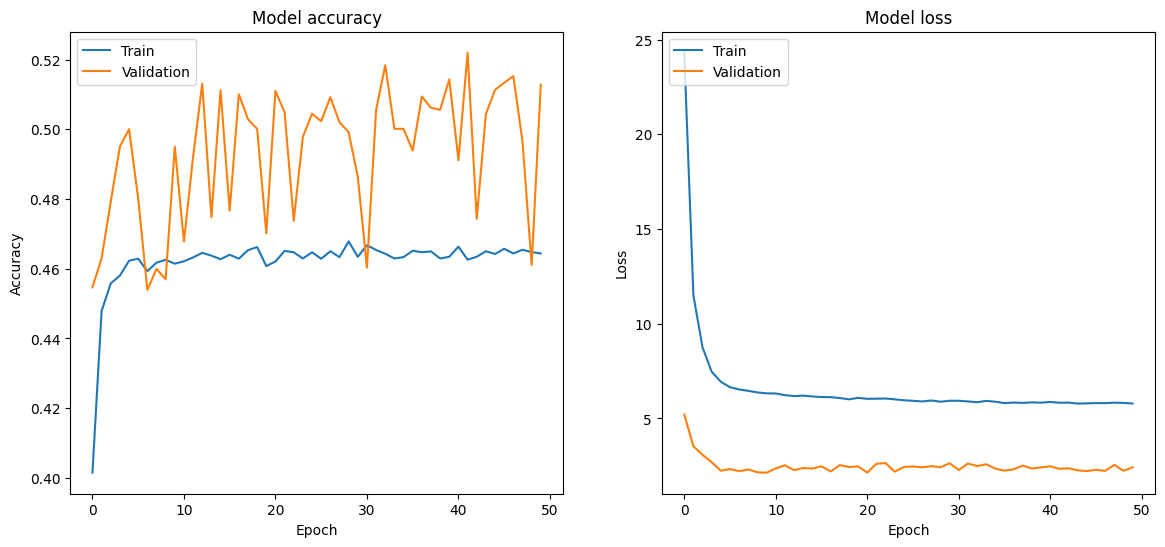

In [63]:
# Evaluate the model
evaluation_results = model.evaluate(
    [X_home_test, X_away_test, X_home_team_test, X_away_team_test, historical_stats_test],
    {'result': y_result_one_hot_test, 'total_goals': y_total_goals_test, 'total_corners': y_total_corners_test, 'total_cards': y_total_cards_test}
)

# Extract individual metrics
loss = evaluation_results[0]
accuracy = evaluation_results[1]
mse_goals = evaluation_results[3]
mse_corners = evaluation_results[5]
mse_cards = evaluation_results[7]

print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')
print(f'Test MSE Goals: {mse_goals}')
print(f'Test MSE Corners: {mse_corners}')
print(f'Test MSE Cards: {mse_cards}')

# Visualize training results
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['result_accuracy'])
plt.plot(history.history['val_result_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Epoch 1/50
1322/1322 [==============================] - 4s 3ms/step - loss: 5.7887 - result_loss: 1.0454 - total_goals_loss: 0.7888 - total_corners_loss: 2.3736 - total_cards_loss: 1.1476 - result_accuracy: 0.4640 - total_goals_mse: 0.7888 - total_corners_mse: 2.3736 - total_cards_mse: 1.1476 - val_loss: 2.3436 - val_result_loss: 1.0295 - val_total_goals_loss: 0.2864 - val_total_corners_loss: 0.2669 - val_total_cards_loss: 0.3270 - val_result_accuracy: 0.5087 - val_total_goals_mse: 0.2864 - val_total_corners_mse: 0.2669 - val_total_cards_mse: 0.3270
Epoch 2/50
1322/1322 [==============================] - 4s 3ms/step - loss: 5.8106 - result_loss: 1.0455 - total_goals_loss: 0.7804 - total_corners_loss: 2.3990 - total_cards_loss: 1.1530 - result_accuracy: 0.4672 - total_goals_mse: 0.7804 - total_corners_mse: 2.3990 - total_cards_mse: 1.1530 - val_loss: 2.2927 - val_result_loss: 1.0319 - val_total_goals_loss: 0.2361 - val_total_corners_loss: 0.3216 - val_total_cards_loss: 0.2753 - val_resu

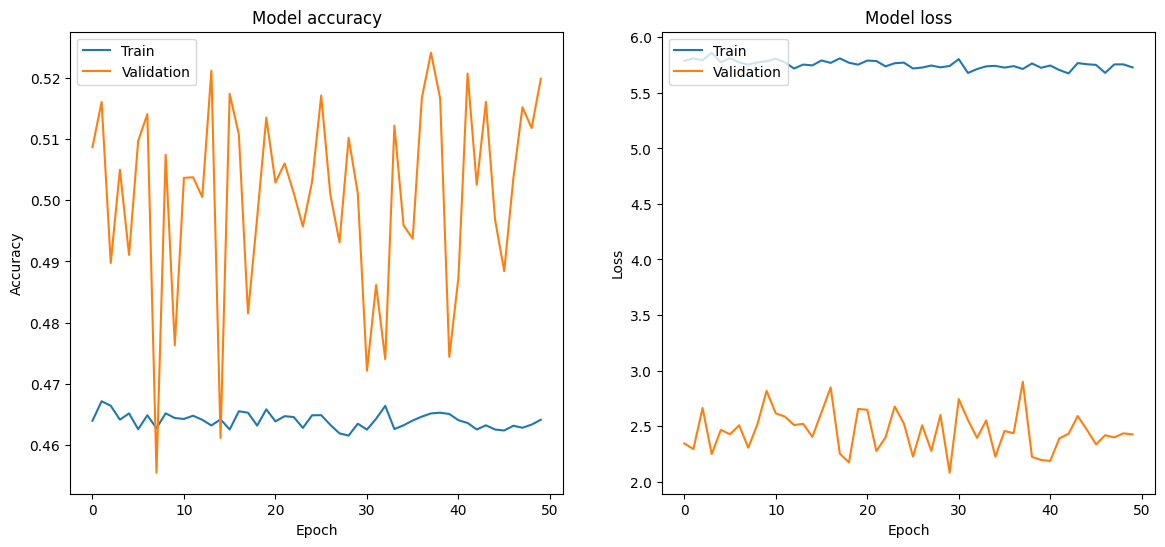

In [65]:
# Train the model
history = model.fit(
    [X_home_train, X_away_train, X_home_team_train, X_away_team_train, historical_stats_train],
    {'result': y_result_one_hot, 'total_goals': y_total_goals, 'total_corners': y_total_corners, 'total_cards': y_total_cards},
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

# Evaluate the model
evaluation_results = model.evaluate(
    [X_home_test, X_away_test, X_home_team_test, X_away_team_test, historical_stats_test],
    {'result': y_result_one_hot_test, 'total_goals': y_total_goals_test, 'total_corners': y_total_corners_test, 'total_cards': y_total_cards_test}
)

# Ensure the correct interpretation of metrics
results = dict(zip(model.metrics_names, evaluation_results))

print(f"Test loss: {results['loss']}")
print(f"Test accuracy: {results['result_accuracy']}")
print(f"Test MSE Goals: {results['total_goals_mse']}")
print(f"Test MSE Corners: {results['total_corners_mse']}")
print(f"Test MSE Cards: {results['total_cards_mse']}")

# Visualize training results
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['result_accuracy'])
plt.plot(history.history['val_result_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


413/413 [==============================] - 1s 3ms/step - loss: 2.4429 - result_loss: 1.0321 - total_goals_loss: 0.2935 - total_corners_loss: 0.4630 - total_cards_loss: 0.2233 - result_accuracy: 0.5190 - total_goals_mse: 0.2935 - total_corners_mse: 0.4630 - total_cards_mse: 0.2233
Test loss: 2.4429497718811035
Test accuracy: 0.5189921259880066
Test MSE Goals: 0.2934606075286865
Test MSE Corners: 0.46300020813941956
Test MSE Cards: 0.22325588762760162


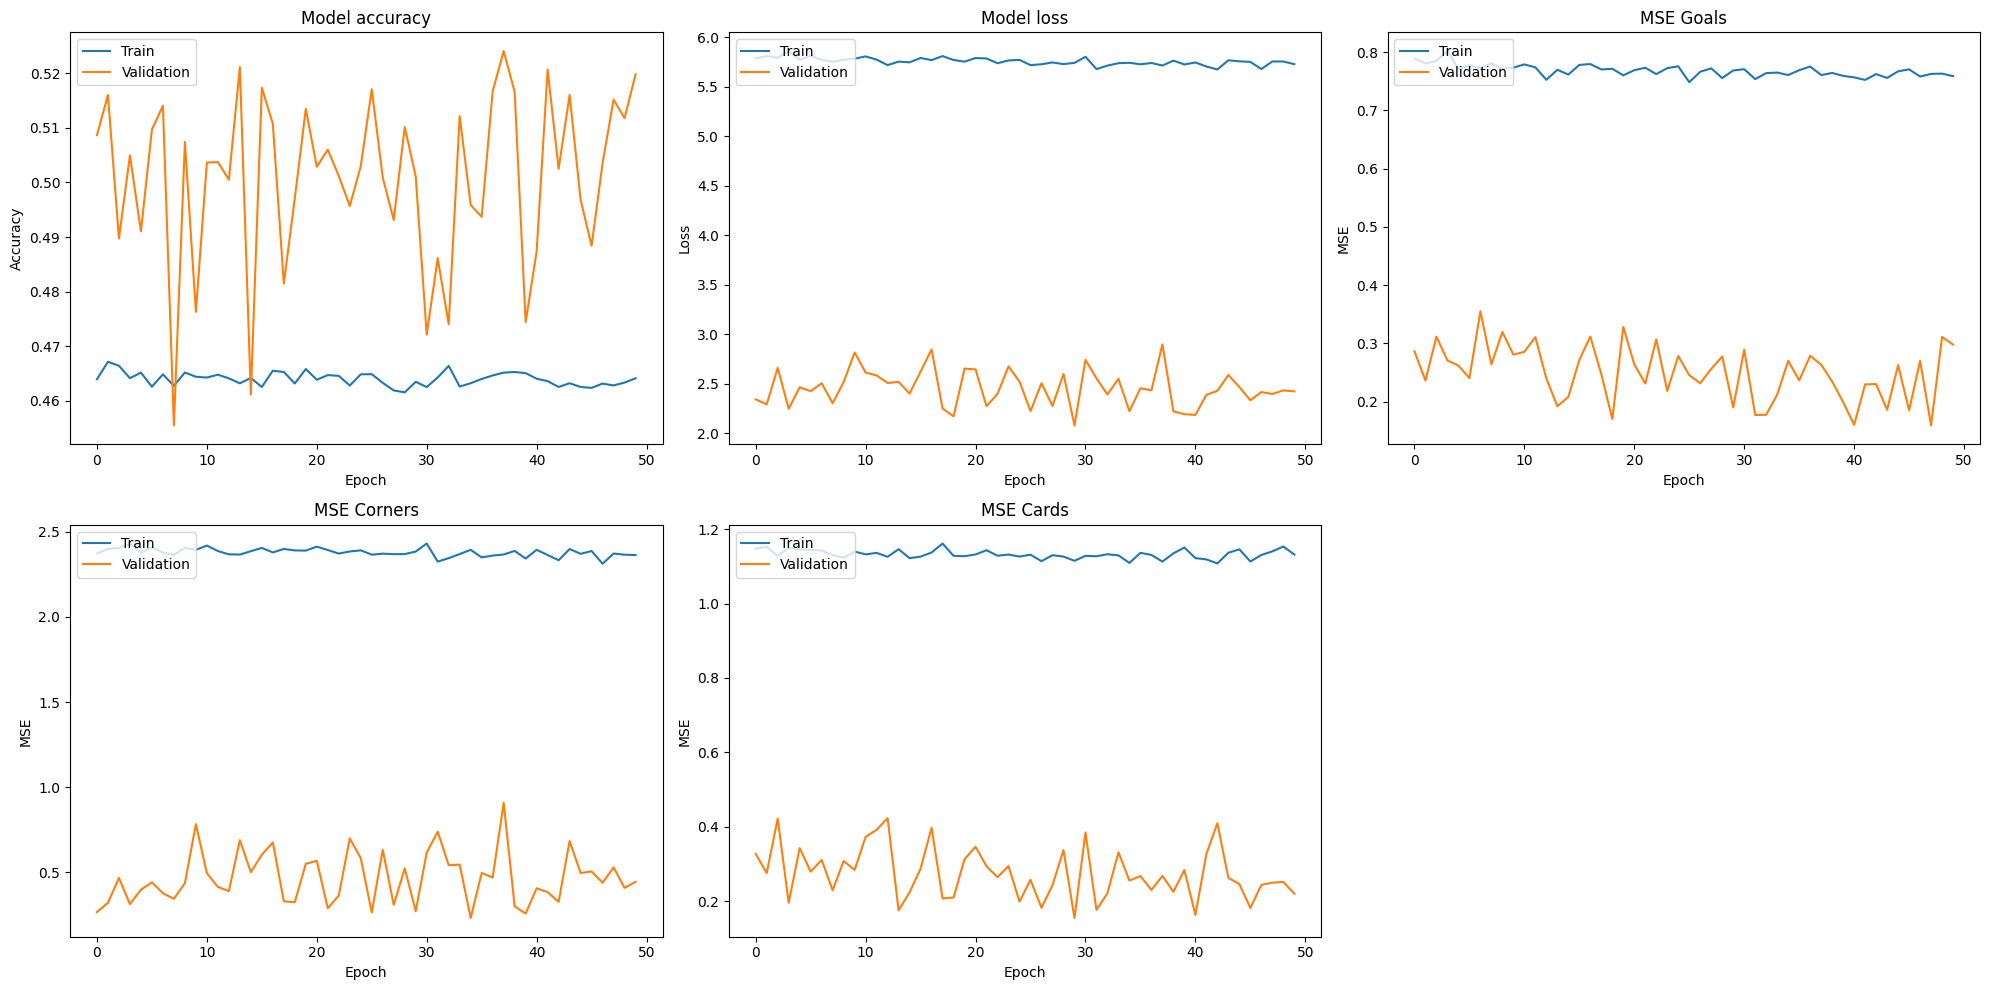

In [66]:
# Evaluate the model
evaluation_results = model.evaluate(
    [X_home_test, X_away_test, X_home_team_test, X_away_team_test, historical_stats_test],
    {'result': y_result_one_hot_test, 'total_goals': y_total_goals_test, 'total_corners': y_total_corners_test, 'total_cards': y_total_cards_test}
)

# Ensure the correct interpretation of metrics
results = dict(zip(model.metrics_names, evaluation_results))

print(f"Test loss: {results['loss']}")
print(f"Test accuracy: {results['result_accuracy']}")
print(f"Test MSE Goals: {results['total_goals_mse']}")
print(f"Test MSE Corners: {results['total_corners_mse']}")
print(f"Test MSE Cards: {results['total_cards_mse']}")

# Visualize training results
plt.figure(figsize=(20, 10))

# Accuracy
plt.subplot(2, 3, 1)
plt.plot(history.history['result_accuracy'])
plt.plot(history.history['val_result_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss
plt.subplot(2, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# MSE Goals
plt.subplot(2, 3, 3)
plt.plot(history.history['total_goals_mse'])
plt.plot(history.history['val_total_goals_mse'])
plt.title('MSE Goals')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# MSE Corners
plt.subplot(2, 3, 4)
plt.plot(history.history['total_corners_mse'])
plt.plot(history.history['val_total_corners_mse'])
plt.title('MSE Corners')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# MSE Cards
plt.subplot(2, 3, 5)
plt.plot(history.history['total_cards_mse'])
plt.plot(history.history['val_total_cards_mse'])
plt.title('MSE Cards')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [70]:
def predict(home_team, away_team, home_form, away_form):
    # Encode team names
    home_team_encoded = le.transform([home_team])
    away_team_encoded = le.transform([away_team])

    # Prepare form input
    home_form_array = np.array(home_form).reshape(1, -1)
    away_form_array = np.array(away_form).reshape(1, -1)
    
    # Create a dummy stats array with the same shape as used in training
    dummy_stats = np.zeros((1, 26))

    # Predict
    prediction = model.predict([home_form_array, away_form_array, home_team_encoded, away_team_encoded, dummy_stats])
    result_pred, goals_pred, corners_pred, cards_pred = prediction

    # Convert the result prediction from one-hot encoding to class label
    result_class = np.argmax(result_pred, axis=1)[0]
    return {
        'result': result_class,
        'total_goals': goals_pred[0][0],
        'total_corners': corners_pred[0][0],
        'total_cards': cards_pred[0][0]
    }

In [81]:
home_team = 'Arsenal'
away_team = 'Manchester United'
home_form = [1, 0, -1, 1, 0]  # Example form
away_form = [-1, 1, 0, -1, 1]  # Example form

prediction = predict(home_team, away_team, home_form, away_form)

1/1 [==============================] - 0s 26ms/step


In [82]:
prediction

{'result': 0,
 'total_goals': 0.87195015,
 'total_corners': -0.36573505,
 'total_cards': 0.33170176}

In [69]:
predictor = FootballMatchPredictor(896)

NameError: name 'FootballMatchPredictor' is not defined

In [87]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, concatenate, Dropout
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

class MatchPredictor:
    def __init__(self, num_teams, input_shape_stats):
        self.num_teams = num_teams
        self.input_shape_stats = input_shape_stats
        self.model = self.build_model()

    def build_model(self):
        # Inputs
        home_form_input = Input(shape=(5,))
        away_form_input = Input(shape=(5,))
        home_team_input = Input(shape=(1,))
        away_team_input = Input(shape=(1,))
        stats_input = Input(shape=(self.input_shape_stats,))

        # Team embeddings
        home_team_embedding = Embedding(input_dim=self.num_teams, output_dim=32)(home_team_input)
        home_team_embedding = Flatten()(home_team_embedding)

        away_team_embedding = Embedding(input_dim=self.num_teams, output_dim=32)(away_team_input)
        away_team_embedding = Flatten()(away_team_embedding)

        # Combine all inputs
        merged = concatenate([home_form_input, away_form_input, home_team_embedding, away_team_embedding, stats_input])
        merged = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(merged)
        merged = Dropout(0.5)(merged)
        merged = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(merged)
        merged = Dropout(0.5)(merged)

        # Output layers
        result_output = Dense(3, activation='softmax', name='result')(merged)
        goals_output = Dense(1, activation='linear', name='total_goals')(merged)
        corners_output = Dense(1, activation='linear', name='total_corners')(merged)
        cards_output = Dense(1, activation='linear', name='total_cards')(merged)

        # Create model
        model = Model(inputs=[home_form_input, away_form_input, home_team_input, away_team_input, stats_input],
                      outputs=[result_output, goals_output, corners_output, cards_output])

        model.compile(optimizer='adam',
                      loss={'result': 'categorical_crossentropy', 'total_goals': 'mse', 'total_corners': 'mse', 'total_cards': 'mse'},
                      metrics={'result': 'accuracy', 'total_goals': 'mse', 'total_corners': 'mse', 'total_cards': 'mse'})

        return model

    def train(self, X_home_train, X_away_train, X_home_team_train, X_away_team_train, historical_stats_train, 
              y_result_one_hot, y_total_goals, y_total_corners, y_total_cards, epochs=50, batch_size=32, validation_split=0.2):
        history = self.model.fit(
            [X_home_train, X_away_train, X_home_team_train, X_away_team_train, historical_stats_train],
            {'result': y_result_one_hot, 'total_goals': y_total_goals, 'total_corners': y_total_corners, 'total_cards': y_total_cards},
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split
        )
        return history

    def evaluate(self, X_home_test, X_away_test, X_home_team_test, X_away_team_test, historical_stats_test, 
                 y_result_one_hot_test, y_total_goals_test, y_total_corners_test, y_total_cards_test):
        results = self.model.evaluate(
            [X_home_test, X_away_test, X_home_team_test, X_away_team_test, historical_stats_test],
            {'result': y_result_one_hot_test, 'total_goals': y_total_goals_test, 'total_corners': y_total_corners_test, 'total_cards': y_total_cards_test}
        )
        return results

    def predict(self, home_team, away_team, home_form, away_form):
        home_team_encoded = self.label_encoder.transform([home_team])
        away_team_encoded = self.label_encoder.transform([away_team])
        
        home_form_array = np.array([home_form])
        away_form_array = np.array([away_form])
        historical_stats_array = np.zeros((1, self.input_shape_stats))  # Zero array for historical stats
        
        predictions = self.model.predict([home_form_array, away_form_array, home_team_encoded, away_team_encoded, historical_stats_array])
        
        result = np.argmax(predictions[0], axis=1)[0]
        total_goals = int(np.round(predictions[1][0][0]))
        total_corners = int(np.round(predictions[2][0][0]))
        total_cards = int(np.round(predictions[3][0][0]))

        return {'result': result, 'total_goals': max(0, total_goals), 'total_corners': max(0, total_corners), 'total_cards': max(0, total_cards)}

    def visualize_training(self, history):
        plt.figure(figsize=(14, 6))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['result_accuracy'])
        plt.plot(history.history['val_result_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.show()

In [89]:
# Zdefiniowanie liczby drużyn i kształtu danych statystyk historycznych
num_teams = len(le.classes_)
input_shape_stats = 26

# Utworzenie instancji modelu
predictor = MatchPredictor(num_teams, input_shape_stats)

In [90]:
# Trening modelu
history = predictor.train(X_home_train, X_away_train, X_home_team_train, X_away_team_train, historical_stats_train, 
                          y_result_one_hot, y_total_goals, y_total_corners, y_total_cards, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
   1/1322 [..............................] - ETA: 45:23 - loss: 286.9275 - result_loss: 9.3342 - total_goals_loss: 96.3724 - total_corners_loss: 103.1972 - total_cards_loss: 76.0604 - result_accuracy: 0.3750 - total_goals_mse: 96.3724 - total_corners_mse: 103.1972 - total_cards_mse: 76.0604

InvalidArgumentError: Graph execution error:

Detected at node model_4/embedding_9/embedding_lookup defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\asyncio\events.py", line 80, in _run

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33128\1557024384.py", line 2, in <module>

  File "C:\Users\Łukasz\AppData\Local\Temp\ipykernel_33128\56371510.py", line 54, in train

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call

indices[30,0] = 895 is not in [0, 895)
	 [[{{node model_4/embedding_9/embedding_lookup}}]] [Op:__inference_train_function_1881081]

In [97]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, concatenate, Dropout
from keras.regularizers import l2
import matplotlib.pyplot as plt

# Przygotowanie danych
# data = pd.read_csv('path_to_your_dataset.csv')

# Zakodowanie nazw drużyn
label_encoder = LabelEncoder()
data['home_team_encoded'] = label_encoder.fit_transform(data['home_team_name'])
data['away_team_encoded'] = label_encoder.fit_transform(data['away_team_name'])

# Podział danych na zbiór treningowy i testowy
from sklearn.model_selection import train_test_split
X = data[['home_last_5', 'away_last_5', 'home_team_encoded', 'away_team_encoded', 'home_ppg', 'away_ppg',
          'home_team_goal_count', 'away_team_goal_count', 'total_goal_count', 'total_goals_at_half_time',
          'home_team_corner_count', 'away_team_corner_count', 'home_team_yellow_cards', 'away_team_yellow_cards',
          'home_team_red_cards', 'away_team_red_cards', 'home_team_first_half_cards', 'away_team_first_half_cards',
          'home_team_second_half_cards', 'away_team_second_half_cards', 'home_team_shots', 'away_team_shots',
          'home_team_shots_on_target', 'away_team_shots_on_target', 'home_team_shots_off_target', 'away_team_shots_off_target',
          'home_team_fouls', 'away_team_fouls', 'home_team_possession', 'away_team_possession', 'Home Team Pre-Match xG',
          'Away Team Pre-Match xG', 'team_a_xg', 'team_b_xg', 'average_goals_per_match_pre_match', 'btts_percentage_pre_match',
          'over_15_percentage_pre_match', 'over_25_percentage_pre_match', 'over_35_percentage_pre_match',
          'over_45_percentage_pre_match', 'over_15_HT_FHG_percentage_pre_match', 'over_05_HT_FHG_percentage_pre_match',
          'over_15_2HG_percentage_pre_match', 'over_05_2HG_percentage_pre_match', 'average_corners_per_match_pre_match',
          'average_cards_per_match_pre_match', 'odds_ft_home_team_win', 'odds_ft_draw', 'odds_ft_away_team_win',
          'odds_ft_over15', 'odds_ft_over25', 'odds_ft_over35', 'odds_ft_over45', 'odds_btts_yes', 'odds_btts_no']]
y = data[['result', 'total_goal_count', 'corners_total', 'cards_total']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standaryzacja danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Rozdzielenie etykiet na poszczególne zmienne
y_result_train = pd.get_dummies(y_train['result'])
y_result_test = pd.get_dummies(y_test['result'])
y_total_goals_train = y_train['total_goal_count'].values
y_total_goals_test = y_test['total_goal_count'].values
y_total_corners_train = y_train['corners_total'].values
y_total_corners_test = y_test['corners_total'].values
y_total_cards_train = y_train['cards_total'].values
y_total_cards_test = y_test['cards_total'].values

ValueError: setting an array element with a sequence.

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, concatenate, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

class MatchPredictor:
    def __init__(self, num_teams, input_shape_stats):
        self.num_teams = num_teams
        self.input_shape_stats = input_shape_stats
        self.label_encoder = LabelEncoder()
        self.model = self.build_model()

    def build_model(self):
        # Inputs
        home_team_input = Input(shape=(1,))
        away_team_input = Input(shape=(1,))
        stats_input = Input(shape=(self.input_shape_stats,))

        # Team embeddings
        home_team_embedding = Embedding(input_dim=self.num_teams, output_dim=32)(home_team_input)
        home_team_embedding = Flatten()(home_team_embedding)

        away_team_embedding = Embedding(input_dim=self.num_teams, output_dim=32)(away_team_input)
        away_team_embedding = Flatten()(away_team_embedding)

        # Combine all inputs
        merged = concatenate([home_team_embedding, away_team_embedding, stats_input])
        merged = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(merged)
        merged = Dropout(0.5)(merged)
        merged = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(merged)
        merged = Dropout(0.5)(merged)

        # Output layers
        result_output = Dense(3, activation='softmax', name='result')(merged)
        goals_output = Dense(1, activation='linear', name='total_goals')(merged)
        corners_output = Dense(1, activation='linear', name='total_corners')(merged)
        cards_output = Dense(1, activation='linear', name='total_cards')(merged)

        # Create model
        model = Model(inputs=[home_team_input, away_team_input, stats_input],
                      outputs=[result_output, goals_output, corners_output, cards_output])

        model.compile(optimizer=Adam(),
                      loss={'result': 'categorical_crossentropy', 'total_goals': 'mse', 'total_corners': 'mse', 'total_cards': 'mse'},
                      metrics={'result': 'accuracy', 'total_goals': 'mse', 'total_corners': 'mse', 'total_cards': 'mse'})

        return model

    def train(self, X_home_team_train, X_away_team_train, historical_stats_train, 
              y_result_train, y_total_goals_train, y_total_corners_train, y_total_cards_train, epochs=50, batch_size=32, validation_split=0.2):
        history = self.model.fit(
            [X_home_team_train, X_away_team_train, historical_stats_train],
            {'result': y_result_train, 'total_goals': y_total_goals_train, 'total_corners': y_total_corners_train, 'total_cards': y_total_cards_train},
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split
        )
        return history

    def evaluate(self, X_home_team_test, X_away_team_test, historical_stats_test, 
                 y_result_test, y_total_goals_test, y_total_corners_test, y_total_cards_test):
        results = self.model.evaluate(
            [X_home_team_test, X_away_team_test, historical_stats_test],
            {'result': y_result_test, 'total_goals': y_total_goals_test, 'total_corners': y_total_corners_test, 'total_cards': y_total_cards_test}
        )
        return results

    def predict(self, home_team, away_team):
        home_team_encoded = self.label_encoder.transform([home_team])
        away_team_encoded = self.label_encoder.transform([away_team])
        
        historical_stats_array = np.zeros((1, self.input_shape_stats))  # Zero array for historical stats
        
        predictions = self.model.predict([home_team_encoded, away_team_encoded, historical_stats_array])
        
        result = np.argmax(predictions[0], axis=1)[0]
        total_goals = int(np.round(predictions[1][0][0]))
        total_corners = int(np.round(predictions[2][0][0]))
        total_cards = int(np.round(predictions[3][0][0]))

        return {'result': result, 'total_goals': max(0, total_goals), 'total_corners': max(0, total_corners), 'total_cards': max(0, total_cards)}

    def visualize_training(self, history):
        plt.figure(figsize=(14, 6))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['result_accuracy'])
        plt.plot(history.history['val_result_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.show()


In [121]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Załaduj dane
# data = pd.read_csv('football_data.csv')

# Usunięcie kolumn home_last_5 i away_last_5
# data = data.drop(columns=['home_last_5', 'away_last_5'])

# Preprocessing pozostałych danych
# data['date_GMT'] = pd.to_datetime(data['date_GMT'])
# data = data.sort_values(by='date_GMT')

# Rozdzielenie danych na cechy i etykiety
X = data.drop(columns=['result', 'total_goal_count', 'corners_total', 'cards_total'])
# X = data.drop(['referee', 'stadium_name', 'attendance', 'date', 'time', 'season'], axis=1, inplace=True)
y_result = data['result']
y_total_goals = data['total_goal_count']
y_total_corners = data['corners_total']
y_total_cards = data['cards_total']

# Kodowanie etykiet drużyn
le = LabelEncoder()
X['home_team_name'] = le.fit_transform(X['home_team_name'])
X['away_team_name'] = le.fit_transform(X['away_team_name'])

# Rozdzielenie danych na zbiory treningowy i testowy
X_train, X_test, y_train_result, y_test_result = train_test_split(X, y_result, test_size=0.2, random_state=42)
X_train, X_test, y_train_total_goals, y_test_total_goals = train_test_split(X, y_total_goals, test_size=0.2, random_state=42)
X_train, X_test, y_train_total_corners, y_test_total_corners = train_test_split(X, y_total_corners, test_size=0.2, random_state=42)
X_train, X_test, y_train_total_cards, y_test_total_cards = train_test_split(X, y_total_cards, test_size=0.2, random_state=42)

# Standaryzacja danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [123]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, concatenate
from keras.utils import to_categorical

# Definiowanie modelu
input_home_team = Input(shape=(1,), name='home_team')
input_away_team = Input(shape=(1,), name='away_team')

embedding_home_team = Embedding(input_dim=len(le.classes_), output_dim=10, input_length=1)(input_home_team)
embedding_away_team = Embedding(input_dim=len(le.classes_), output_dim=10, input_length=1)(input_away_team)

flatten_home_team = Flatten()(embedding_home_team)
flatten_away_team = Flatten()(embedding_away_team)

input_features = Input(shape=(X_train_scaled.shape[1],), name='match_features')

concatenated = concatenate([flatten_home_team, flatten_away_team, input_features])

dense1 = Dense(128, activation='relu')(concatenated)
dense2 = Dense(64, activation='relu')(dense1)

output_result = Dense(3, activation='softmax', name='result')(dense2)
output_total_goals = Dense(1, name='total_goals')(dense2)
output_total_corners = Dense(1, name='total_corners')(dense2)
output_total_cards = Dense(1, name='total_cards')(dense2)

model = Model(inputs=[input_home_team, input_away_team, input_features], outputs=[output_result, output_total_goals, output_total_corners, output_total_cards])

model.compile(optimizer='adam',
              loss={'result': 'categorical_crossentropy', 'total_goals': 'mse', 'total_corners': 'mse', 'total_cards': 'mse'},
              metrics={'result': 'accuracy', 'total_goals': 'mse', 'total_corners': 'mse', 'total_cards': 'mse'})

# One-hot encoding for result
y_train_result_one_hot = to_categorical(y_train_result)
y_test_result_one_hot = to_categorical(y_test_result)


In [125]:
# Przygotowanie danych (zaktualizuj według swoich danych)
num_teams = len(le.classes_)
input_shape_stats = X_train_scaled.shape[1]

predictor = MatchPredictor(num_teams, input_shape_stats)

# Trening modelu
history = predictor.train(X_train['home_team_name'], X_train['away_team_name'], X_train_scaled,
                          y_train_result_one_hot, y_train_total_goals, y_train_total_corners, y_train_total_cards)


Epoch 1/50
1322/1322 [==============================] - 7s 4ms/step - loss: nan - result_loss: 1.0804 - total_goals_loss: 3.8423 - total_corners_loss: 43.0963 - total_cards_loss: 8.4239 - result_accuracy: 0.4380 - total_goals_mse: 3.8423 - total_corners_mse: 43.0963 - total_cards_mse: 8.4239 - val_loss: nan - val_result_loss: 1.0678 - val_total_goals_loss: 2.8070 - val_total_corners_loss: 32.1182 - val_total_cards_loss: 5.8590 - val_result_accuracy: 0.4516 - val_total_goals_mse: 2.8070 - val_total_corners_mse: 32.1182 - val_total_cards_mse: 5.8590
Epoch 2/50
1322/1322 [==============================] - 4s 3ms/step - loss: nan - result_loss: 1.0704 - total_goals_loss: 3.0186 - total_corners_loss: 33.7006 - total_cards_loss: 6.4975 - result_accuracy: 0.4502 - total_goals_mse: 3.0186 - total_corners_mse: 33.7006 - total_cards_mse: 6.4975 - val_loss: nan - val_result_loss: 1.0670 - val_total_goals_loss: 2.8130 - val_total_corners_loss: 32.1104 - val_total_cards_loss: 5.8587 - val_result_ac

In [99]:
data['away_last_5']

0         [-1, -1, 1, -2, -1]
1             [0, 0, 0, 0, 0]
2             [0, 0, 0, 0, 0]
3             [0, 0, 0, 0, 0]
4             [0, 0, 0, 0, 0]
                 ...         
66075    [-3, -3, -3, -3, -3]
66076       [-2, 0, 0, -2, 3]
66077      [-2, -2, -1, 0, 3]
66078       [2, 1, -3, 2, -1]
66079        [0, 3, 1, 3, -1]
Name: away_last_5, Length: 66080, dtype: object

In [126]:
results = predictor.evaluate(X_test['home_team_name'], X_test['away_team_name'], X_test_scaled,
                             y_test_result_one_hot, y_test_total_goals, y_test_total_corners, y_test_total_cards)
print(results)

413/413 [==============================] - 1s 2ms/step - loss: nan - result_loss: 1.0659 - total_goals_loss: 2.7432 - total_corners_loss: 31.7274 - total_cards_loss: 5.9633 - result_accuracy: 0.4519 - total_goals_mse: 2.7432 - total_corners_mse: 31.7274 - total_cards_mse: 5.9633
[nan, 1.065895915031433, 2.7432236671447754, 31.72736930847168, 5.963280200958252, 0.45187652111053467, 2.7432236671447754, 31.72736930847168, 5.963280200958252]
